# Predicting Reddit User Location

**Background Information**

On reddit there are regional subreddits. Regional subreddits are essentially forums that are used to discuss topics specific to a region. r/vancouver, r/Seattle, and r/japan are examples of these. Importantly, anyone can make comments in these subreddits. This means that someone from say, London, can post on the Vancouver subreddit freely. While this is an issue, a vast majority of those who post to a regional subreddit live in that region. I use the fact that users post in a regional subreddit as a indicator that a particular user belongs to a particular region. By doing this, I creat a training set of users with a "known" region, and use this data to build models at the end of the project. 
 
**Project Description:**

A project where I predict whether a user is in North/South America based on the time of day that they post comments.

**Result**

Using a random forest, users are able to be correctly identified as living in the Americas with 85% accuracy. 

# 1: Exploratory Data Analysis:

Data comes from a BigQuery table that was compiled by some reddit users. It contains all reddit comments from 2005 and is ~4 billion rows of data. 'onlyRegionData.csv' was queried from October 2018 using the following SQL query:




`SELECT author, subreddit, created_utc FROM fh-bigquery.reddit_comments.2018_10`

`WHERE subreddit in ('vancouver', 'nyc', 'Seattle', 'germany', 'Finland', 'sweden', 'unitedkingdom', 'melbourne', 'japan'))`




The WHERE clause subreddits were chosen since they are active regional subreddits. 3 are in the Americas, 4 are in Europe, and 2 are in East Asia/Australia



These subreddits were chosen due to their high activity. Secondly, 'sampleData.csv' is the same query as above but does not include the WHERE clause.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc

plt.style.use('fivethirtyeight')

In [3]:
region_df = pd.read_csv('onlyRegionalData.csv')
users_df = pd.read_csv('sampleData.csv')

There are no missing values for subreddit, created_utc, and author, which is all I'll be using to predict region. 

In [5]:
region_df = region_df[['author', 'body', 'subreddit', 'created_utc']]
users_df = users_df[['author', 'body', 'subreddit', 'created_utc']]

gc.collect()
users_df = users_df.dropna()
users_df.isna().sum()

author         0
body           0
subreddit      0
created_utc    0
dtype: int64

Time/Region

From the data, the time comes in as a UNIX timestamp. Convert it into a datetime object and decompose it into individual columns

In [6]:
from datetime import datetime
import calendar

def getDateTime(data):
    data.created_utc = pd.to_numeric(data.created_utc)
    data['convertedTime'] = pd.to_datetime(data['created_utc'], unit='s')
    data['hour'] =  data['convertedTime'].dt.hour
    data['day'] =  data['convertedTime'].dt.day
    data['month'] =  data['convertedTime'].dt.month
    data['dayOfWeek'] = data['convertedTime'].dt.dayofweek
    return data


users_df = getDateTime(users_df)
region_df = getDateTime(region_df)

Here I prepare dataframes with data from regional subreddits. The hour that comments were posted is adjusted to local time by passing in an offset parameter. For example, PST (Vancouver time) is -8 from UTC. I'll define activity as the number of comments made.

In [7]:
def getRegionalActivity(data, region, offset):
    regionActivity = data[data['subreddit'].isin([region])]
    regionActivity = regionActivity[['author','subreddit', 'created_utc', 'hour', 'day', 'dayOfWeek']]
    regionActivity['offsetHour'] = (regionActivity['hour'] + offset)%24
    return regionActivity
    

germanyActivity = getRegionalActivity(region_df, 'germany', 1)
vancouverActivity = getRegionalActivity(region_df, 'vancouver', -8)
swedenActivity = getRegionalActivity(region_df, 'sweden', 1)

finlandActivity = getRegionalActivity(region_df, 'Finland', 2)
melbourneActivity = getRegionalActivity(region_df, 'melbourne', 10)
unitedkingdomActivity = getRegionalActivity(region_df, 'unitedkingdom' , 0)

seattleActivity = getRegionalActivity(region_df, 'Seattle', -8)
nycActivity = getRegionalActivity(region_df, 'nyc', -5)
japanActivity = getRegionalActivity(region_df, 'japan', 9)

It's clear that peak activity occures at ~1200 local time for most regions. I've seen a figure touted that internet activity tends to peak between the hours of 7-11PM. Interestingly, reddit does not seem to follow this trend. I suspect that it's because people take breaks around noon and thus there is more activity around that time. What's important here is that it seems consistent across regions.

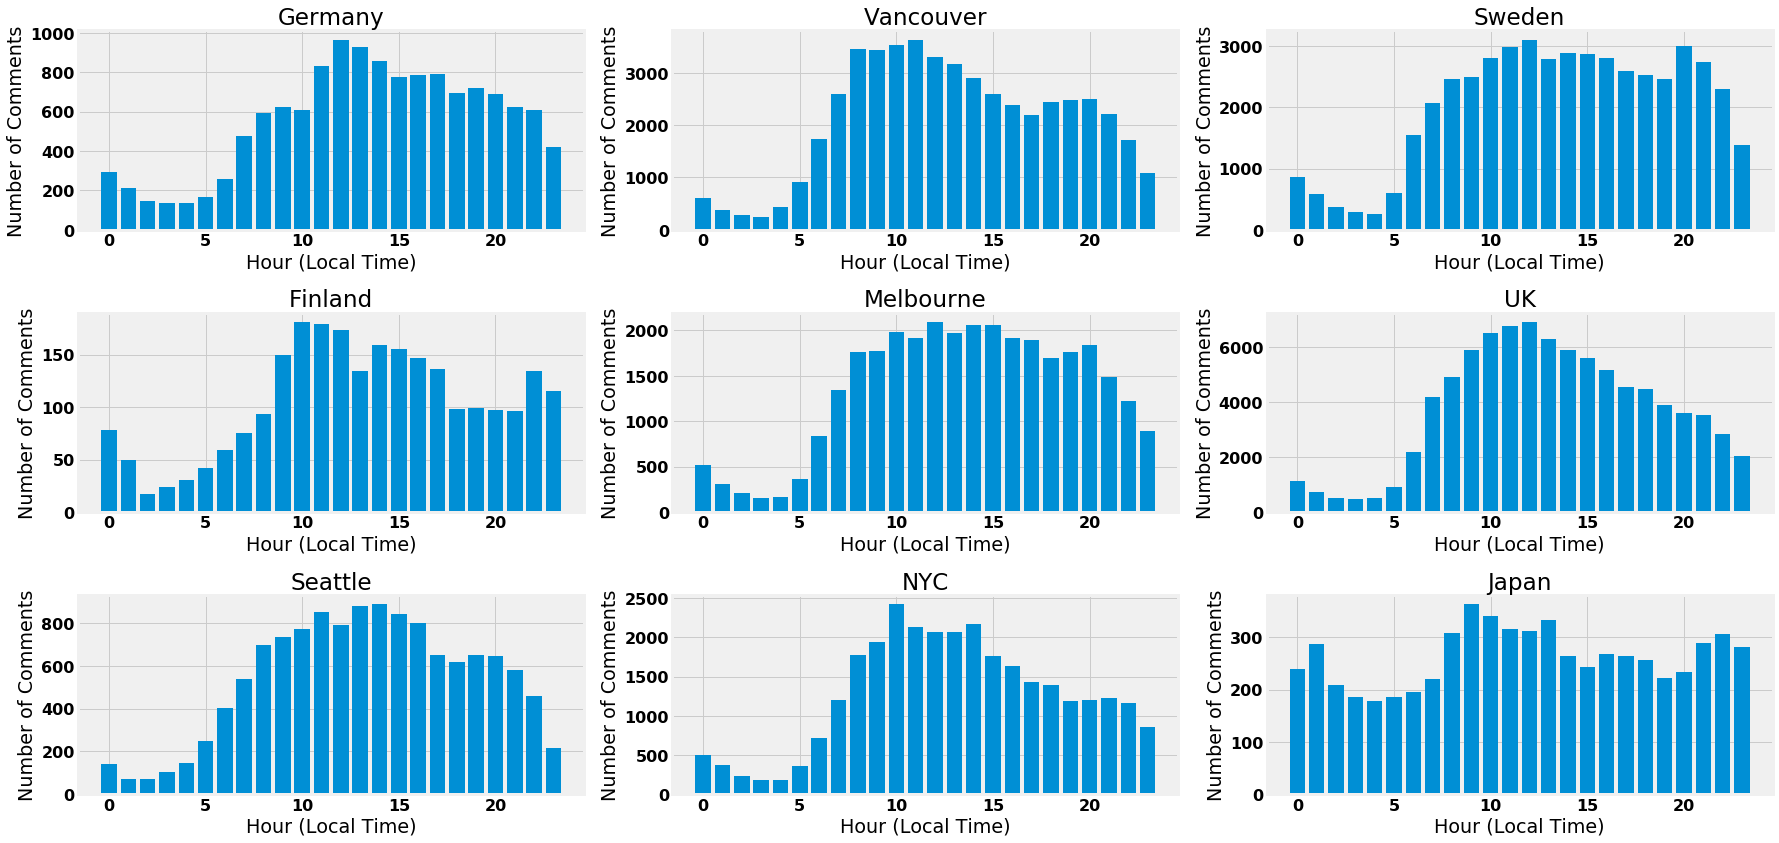

In [9]:
subredditList = [germanyActivity, vancouverActivity, swedenActivity, finlandActivity, melbourneActivity, unitedkingdomActivity, seattleActivity, nycActivity, japanActivity]
subredditTitles = ['Germany', 'Vancouver','Sweden', 'Finland', 'Melbourne', 'UK', 'Seattle', 'NYC', 'Japan']

font = {'weight' : 'bold',
        'size'   : 16}
plt.rcParams["figure.figsize"] = [25,12]
plt.rc('font', **font)
plt.subplots_adjust(left=.125, bottom=.1, right=.9, top=.9, wspace=.2, hspace=.2)


def plotMaxTimes(regionModeList, titleList):
    fig, (axis1) = plt.subplots(1,figsize=(27,8))
    plt.title('Peak Posting Time by Subreddit')
    plt.xlabel('Subreddit')
    plt.ylabel('Hour (Local Time)')
    axis1.bar(x=titleList, height = regionModeList)


def removeWeekend(data):
        weekendList = [5, 6]
        data = data[~data['dayOfWeek'].isin(weekendList)]
        return data
    
#Pass in a bool for includeWeekends
def plotSubredditActivity(regionList, titleList, includeWeekends):
    modeTimeList = []
    if(~includeWeekends):
        for i in range(1, len(regionList)+1):
            regionList[i-1] = removeWeekend(regionList[i-1])
    
    for i in range(1, len(regionList)+1):       
        modeTimeList.append(regionList[i-1]['offsetHour'].mode()[0])
        plt.subplot(3,3, i)
        plt.xlabel('Hour (Local Time)')
        plt.ylabel('Number of Comments')
        plt.title(titleList[i-1])
        d = regionList[i-1].groupby(['offsetHour'])[['offsetHour']].count()
        plt.bar(x = d.index, height = d.offsetHour)
        plt.tight_layout()
    
    #plotMaxTimes(modeTimeList, titleList)
        

plotSubredditActivity(subredditList, subredditTitles, False)


Similar to the previous section, in these next two cells I group activity by region rather than regional subreddit. It's quite clear that different regions have different levels of activity at different times. It seems like the number of posts in hours 0800-1100 are probably the most indicitive of if users live in the Americas.

In [10]:
AmeracasSubredditList = ['vancouver', 'nyc', 'Seattle', 'mexico', 'sanfrancisco', 'Chile', 'argentina', 'houston', 'colorado', 'canada']
EuropeSubredditList = ['germany', 'Finland', 'sweden', 'unitedkingdom', 'hungary', 'france']
AsiaSubredditList = ['melbourne', 'japan', 'india']

Americas_df = region_df[region_df['subreddit'].isin(AmeracasSubredditList )]
Europe_df = region_df[region_df['subreddit'].isin(EuropeSubredditList)]
Asia_df = region_df[region_df['subreddit'].isin(AsiaSubredditList)]
NotAmericas_df = pd.concat([Europe_df, Asia_df])

regionList = [Americas_df, NotAmericas_df]
regionTitles = ['Activity in the Americas', 'Activity Outside of the Americas']

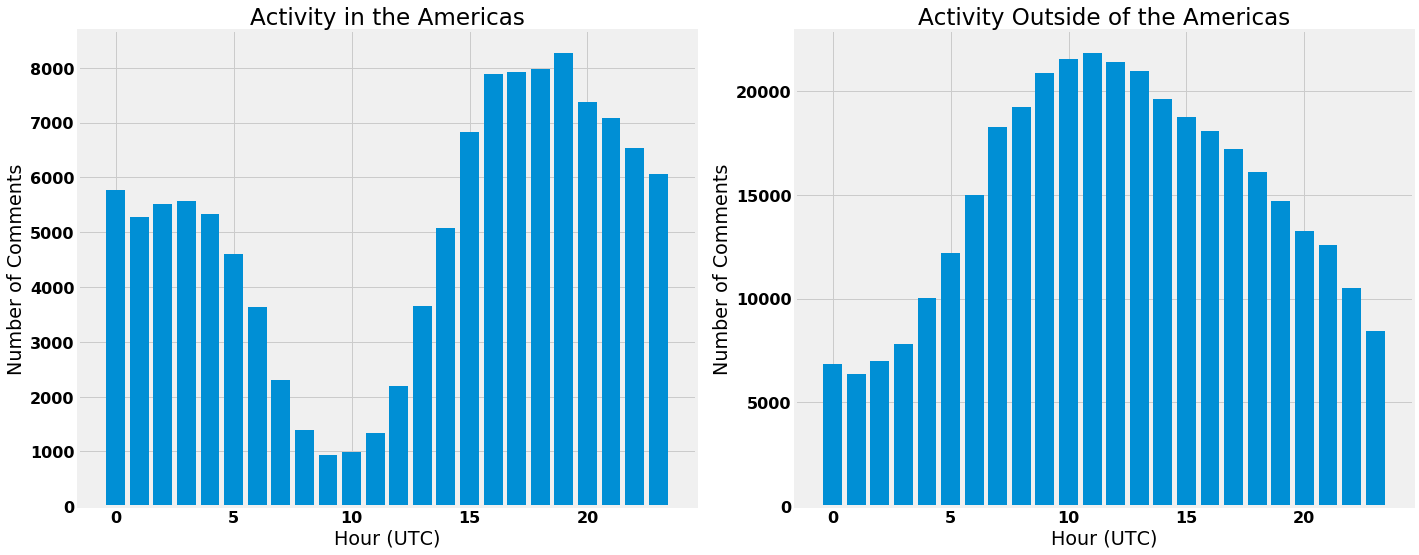

In [11]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rcParams["figure.figsize"] = [20,8]

    
def plotPostActivity(regionList, titleList):
    maxTimeList = []
    for i in range(1, len(regionList)+1):
        maxTimeList.append(regionList[i-1]['hour'].mode()[0])
        
        plt.subplot(1, 2, i)
        plt.xlabel('Hour (UTC)')
        plt.ylabel('Number of Comments')
        plt.title(titleList[i-1])
        
        d = regionList[i-1].groupby(['hour'])[['hour']].count()
        plt.bar(x = d.index, height = d.hour)
        plt.tight_layout()
        
    #plotMaxTimes(maxTimeList, titleList)
       
    
plotPostActivity(regionList, regionTitles)

# 2: Data Processing

'allUsers.csv' was queried in BigQuery using: 

`SELECT author, subreddit, created_utc FROM fh-bigquery.reddit_comments.2018_10`

`WHERE author in (`

`SELECT author FROM fh-bigquery.reddit_comments.2018_10`

`GROUP BY author`

`HAVING COUNT(created_utc)>40)`

`ORDER BY author`

The HAVING clause is there so that only active users are included. It includes 70 million comments made by active users on reddit.



In [13]:
allUsers_df = pd.read_csv('allUsers.csv')
allUsers_df = allUsers_df[['author', 'subreddit', 'created_utc']]

In [14]:
allUsers_df.describe()

,created_utc
count,7.259349e+07
mean,1.539697e+09
std,7.711836e+05
min,1.538352e+09
25%,1.539031e+09
50%,1.539708e+09
75%,1.540362e+09
max,1.541030e+09


In [15]:
allUsers_df.head(5)

,author,subreddit,created_utc
0,shuhup,rupaulsdragrace,1538870402
1,[deleted],interestingasfuck,1538870407
2,TransitionalAhab,exmuslim,1538870412
3,[deleted],unpopularopinion,1538870436
4,aftershock1959,thevenomsite,1538870458


In [17]:
import gc
gc.collect()

0

This cell turns a freshly loaded in dataframe like region_df and bins the number of times a user has made a post in a two hour time interval. For example, if a user made 5 posts at 0100 and 3 posts at 0700, the hour0_1 column would show up as 5 and the hour6_7 column would show up as 3 for that user. Additionally, it labels users who made posts in an Americas subreddit as isNA = 1. Once 
this cell is run, the data becomes the training set where we "know" the user region.

In [24]:
def getDateTime(data):
    data.created_utc = pd.to_numeric(data.created_utc)
    data['convertedTime'] = pd.to_datetime(data['created_utc'], unit='s')
    data['hour'] =  data['convertedTime'].dt.hour
    return data


#Can be expanded upon in the future if more bot authors are discovered
def removeBots(data):
    botAuthors = ['AutoModerator']
    data = data[~data['author'].isin(botAuthors)]
    return data


def removeDeletedAccounts(data):
    return data[~data['author'].isin(['[deleted]'])]


def reset_index(data):
  index_df = data.index.to_frame(index=False)
  data = data.reset_index(drop=True)
  return pd.merge(index_df, data, left_index=True, right_index=True)


#Appends a column labelling the training data as being in the americas
def append_isAmericas(data, NAUsersList):
    data ['isAmericas'] = data['author'].isin(NAUsersList)
    data = data.applymap(lambda x: 1 if x == True else x)
    data = data.applymap(lambda x: 0 if x == False else x)
    return data


#Gets the list of users who live post in a subreddit in subredditList
def getAuthorList(data, subredditList):
    authorList = data[data['subreddit'].isin(subredditList)]
    authorList = authorList.author.unique()
    return authorList


#Return set of users who have made posts in the Americas and notAmericas
def getDuplicateAuthors(userList1, userList2):
    userSet_1 = set(userList1)
    userSet_2 = set(userList2)
    return userSet_1.intersection(userSet_2)
    
#Returns all posts made by users who made a post in one of Americas/notAmericas subreddit lists
def getRegionalAuthorData(data, americasSubredditList, notAmericasSubredditList):
    americasAuthorList = getAuthorList(data, americasSubredditList)
    notAmericasAuthorList = getAuthorList(data, notAmericasSubredditList)
    
    americasData = data[data['author'].isin(americasAuthorList)]
    notAmericasData = data[data['author'].isin(notAmericasAuthorList)]
    return pd.concat([americasData, notAmericasData])


#Get number of posts made by each user in 2 hour bins
#Returns a dataframe with a column for each bin
def binPostActivity(data, americasUsersList):
    data = getDateTime(data)
    bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
    labels = ['hour0_1', 'hour2_3', 'hour4_5', 'hour6_7', 'hour8_9', 'hour10_11', 'hour12_13', 'hour14_15', 
              'hour16_17', 'hour18_19', 'hour20_21', 'hour22_23']
    data = data.groupby(['author', pd.cut(data.hour, bins, right = False, labels = labels, include_lowest = True)])
    data = data.size().unstack(level = -1)
    data = data.fillna(0)
    data = reset_index(data)
    data = append_isAmericas(data, americasUsersList)
    return data

In [25]:
americasSubredditList = ['vancouver', 'nyc', 'Seattle', 'mexico', 'sanfrancisco', 'Chile', 'argentina', 'houston', 'colorado', 'canada']
notAmericasSubredditList = ['germany', 'Finland', 'sweden', 'unitedkingdom', 'hungary', 'france', 'melbourne', 'japan', 'india']

#Calls all the required functions to turn a fresh dataframe into model-ready data
def newDataToModelData(data, americasSubredditList, notAmericasSubredditList):
    data = removeBots(data)
    data = removeDeletedAccounts(data)
    
    #get users who have made a post in a regional subreddit
    modellingData_df = getRegionalAuthorData(data, americasSubredditList, notAmericasSubredditList)
    
    #drop users who have made posts in both Americas and not Americas subreddits
    americasAuthorList = getAuthorList(modellingData_df, americasSubredditList)
    notAmericasAuthorList = getAuthorList(modellingData_df, notAmericasSubredditList)
    duplicateAuthors = getDuplicateAuthors(americasAuthorList, notAmericasAuthorList)
    modellingData_df = modellingData_df[~modellingData_df['author'].isin(duplicateAuthors)]
    
    #bin number of posts users have made
    modellingData_df = binPostActivity(modellingData_df, americasAuthorList)
    return modellingData_df
    

modellingData_df = newDataToModelData(allUsers_df, americasSubredditList, notAmericasSubredditList)

After data processing, there are ~38000 users with known locations. About 60% of these are users are from the Americas. Based on reddit sitewide [statistics from Alexa](https://www.alexa.com/siteinfo/reddit.com) , ~60% of users are from the Americas. This data accurately reflects this statistics since 58% of users are from the Americas in this dataset.

In [26]:
modellingData_df.describe()

,hour0_1,hour2_3,hour4_5,hour6_7,hour8_9,hour10_11,hour12_13,hour14_15,hour16_17,hour18_19,hour20_21,hour22_23,isAmericas
count,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000
mean,12.266803,11.308687,9.079931,7.851306,7.488176,8.855352,12.511325,15.857665,16.683299,16.425035,15.090914,13.134505,0.580719
std,23.453572,22.776447,17.704752,15.360199,17.097618,18.586514,21.102107,24.401756,26.598780,25.102706,23.763211,21.259760,0.493448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.000000,4.000000,4.000000,4.000000,3.000000,0.000000
50%,6.000000,5.000000,4.000000,3.000000,2.000000,3.000000,6.000000,9.000000,10.000000,9.000000,9.000000,7.000000,1.000000
75%,14.000000,13.000000,11.000000,9.000000,9.000000,10.000000,15.000000,19.000000,20.000000,19.000000,18.000000,15.000000,1.000000
max,1339.000000,1283.000000,864.000000,765.000000,1306.000000,1299.000000,1192.000000,1560.000000,1789.000000,1666.000000,1511.000000,1331.000000,1.000000


In [27]:
modellingData_df.tail(10).sort_values(by='author')

,author,hour0_1,hour2_3,hour4_5,hour6_7,hour8_9,hour10_11,hour12_13,hour14_15,hour16_17,hour18_19,hour20_21,hour22_23,isAmericas
38048,zx2167,6.0,5.0,2.0,0.0,0.0,0.0,1.0,9.0,14.0,3.0,11.0,1.0,1
38049,zxdpe,21.0,29.0,16.0,1.0,0.0,6.0,14.0,6.0,23.0,17.0,8.0,11.0,1
38050,zyckness,0.0,0.0,0.0,0.0,0.0,2.0,18.0,0.0,9.0,21.0,4.0,0.0,1
38051,zyl0x,4.0,1.0,1.0,0.0,0.0,7.0,38.0,74.0,40.0,58.0,9.0,2.0,1
38052,zyphelion,4.0,0.0,1.0,3.0,11.0,10.0,4.0,15.0,9.0,2.0,7.0,12.0,0
38053,zyxlon,2.0,1.0,1.0,0.0,0.0,3.0,3.0,4.0,11.0,10.0,7.0,5.0,1
38054,zz-zz,15.0,12.0,10.0,16.0,25.0,26.0,5.0,0.0,0.0,0.0,21.0,20.0,0
38055,zz_,3.0,1.0,6.0,7.0,9.0,22.0,11.0,24.0,4.0,6.0,0.0,0.0,0
38056,zzonked7,0.0,0.0,0.0,0.0,2.0,1.0,1.0,7.0,32.0,14.0,10.0,1.0,0
38057,zzubnik,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,12.0,14.0,10.0,10.0,0


Time bins adjacent to eachother are unsuprisingly highly correlated. As expected, activity in hours (8,9) and0 (10,11) are most correlated with users not living in the Americas.

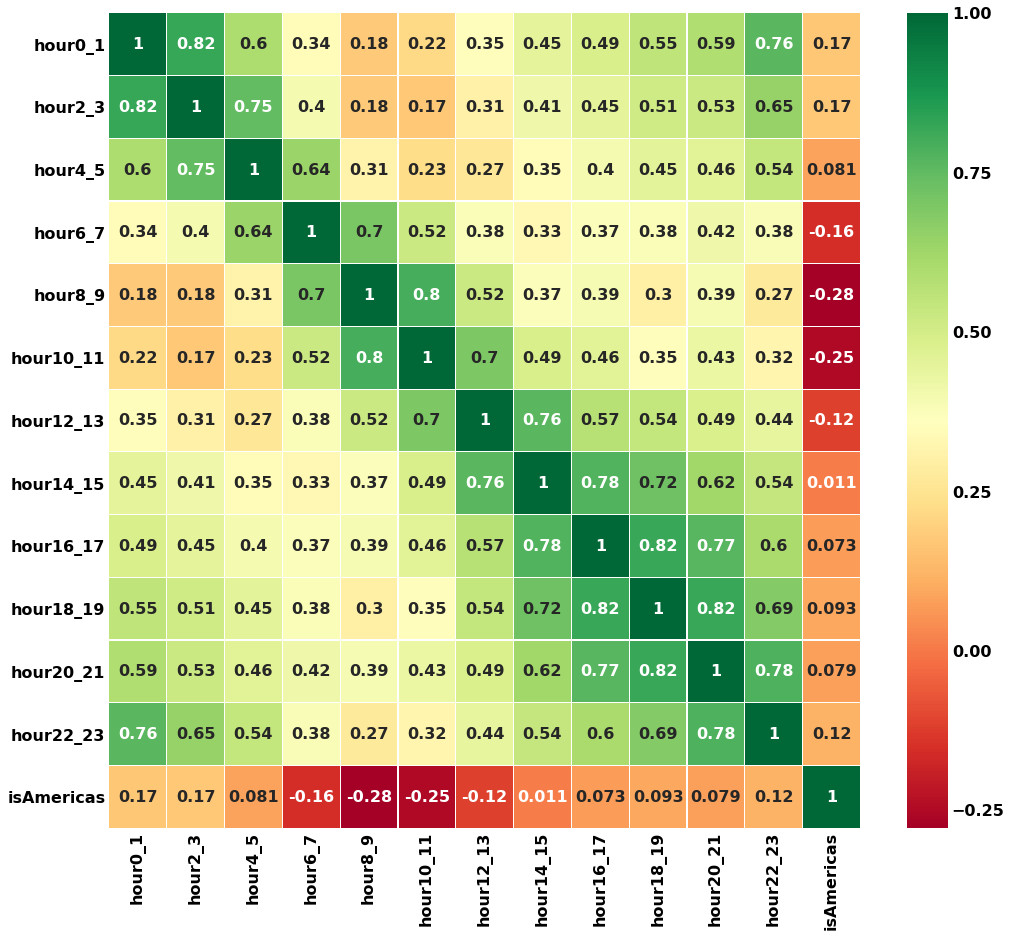

In [29]:
import seaborn as sns
plt.rcParams["figure.figsize"] = [15,15]
sns.heatmap(modellingData_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)

# 3: Modelling

Here I will compare some commonly used models. For all models, I will be using cross validated scores to select hyperparameters. Cross validation is necessary since without it, the training set scores will *always* increase if a new predictor is added. Importantly, since hyperparameters are chosen based on cross validated score, some data will have to be used as a validation set. Since the dataset is fairly large, I'll do a 60/40 split between a validation and training set. 

In [30]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(modellingData_df, test_size=0.6, random_state=1)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict 

train_Y = train['isAmericas']
train_X = train.drop(columns = ['isAmericas', 'author'], axis = 1)

test_Y = test['isAmericas']
test_X = test.drop(columns = ['isAmericas', 'author'], axis = 1)

models = []
modelScores = []
modelSTD = []

In [32]:
LR_model = LogisticRegression(solver = 'lbfgs', penalty = 'l2')
LR_model.fit(train_X, train_Y)

KF = KFold(n_splits=10, random_state=1)
CV = cross_val_score(LR_model,train_X,train_Y,cv=KF, scoring="accuracy")
models.append('LogisticRegression')
modelScores.append(round(CV.mean(),3))
modelSTD.append(round(CV.std(),3))

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()


RF_grid = {"max_depth": [None],
              "max_features": [3, 5, 7],
              "min_samples_split": [4, 6, 8],
              "min_samples_leaf": [5, 7, 10],
              "bootstrap": [True],
              "n_estimators" :[500],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = RF_grid, cv=10, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(train_X,train_Y)

RFC_best = gsRFC.best_estimator_

# Best score
print(gsRFC.best_score_)
print(gsRFC.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.3min finished


0.8504451804378683
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 500}


As expected, hours 8_9, 10_11, and 2_3 are the best indicators of if a user lives in the Americas. These correspond to the times when difference in activty between the Americas and not Americas is the greatest. The difference between the variable important between hour (8,9) and hour (10, 11) is due to the two features being highly correlated (see correlation plot above).

Text(0.5, 1.0, 'Feature Importance')

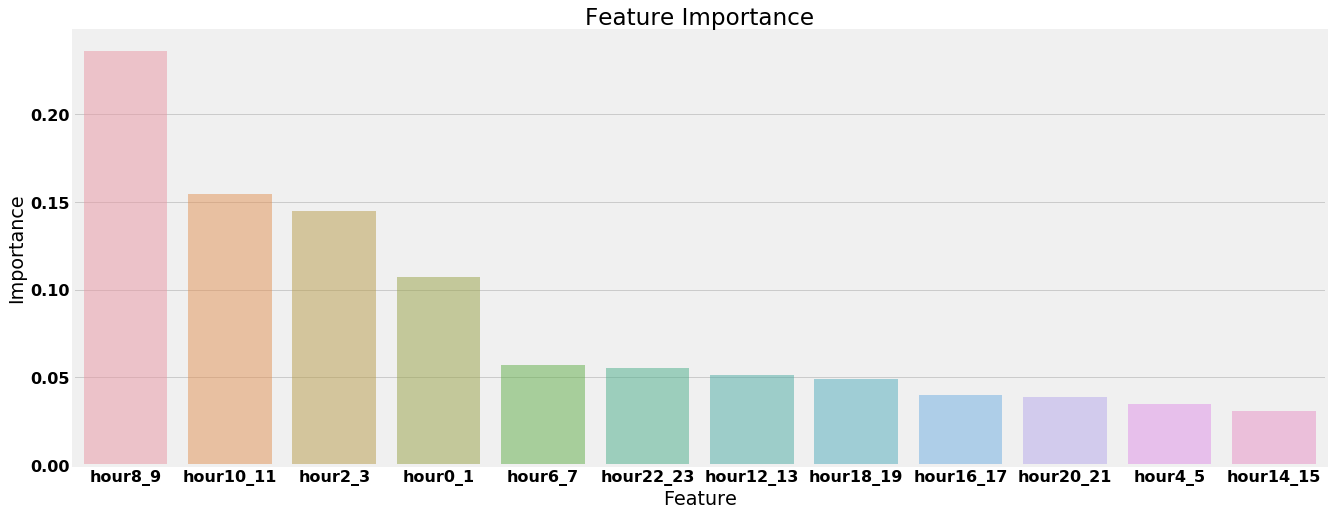

In [33]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
#Random Forest
RF_model = RandomForestClassifier(bootstrap= True, oob_score = True,
 criterion = 'gini',
 max_depth = None,
 max_features=3,
 min_samples_leaf = 5,
 min_samples_split = 6,
 n_estimators = 500, random_state=1)

RF_model.fit(train_X, train_Y)


CV=cross_val_score(RF_model,train_X,train_Y,cv=KF, scoring="accuracy")
models.append('RandomForest')
#modelScores.append(round(RF_model.oob_score_,3))
modelScores.append(round(CV.mean(),3))
modelSTD.append(round(CV.std(),3))

featureImportance = pd.concat((pd.DataFrame(train_X.columns, columns = ['Feature']), 
           pd.DataFrame(RF_model.feature_importances_, columns = ['Importance'])), 
          axis = 1).sort_values(by='Importance', ascending = False)[:20]
plt.subplots(figsize=(20,8))
sns.barplot(x=featureImportance['Feature'], y=featureImportance['Importance'], alpha=.5).set_title('Feature Importance')

The random forest model performs significantly better than the regression. Random forests tend to perform well since they grow many high variance, low bias trees and then take a majority vote which reduces variance. This results in a low bias, low variance model that performs well.

In [38]:
ModelComparison=pd.DataFrame({'CV Score':modelScores, 'Std':modelSTD}, index=models)
ModelComparison

,CV Score,Std
LogisticRegression,0.786,0.009
RandomForest,0.850,0.011


To help assess the model, plot a confusion matrix

In [39]:
predictions = RF_model.predict(test_X)
#predictions.

dtype = [('predictedValues','int32')]
values = np.zeros(20, dtype=dtype)
index = [i for i in range(0, len(predictions))]

df = pd.DataFrame(predictions, index=index)

In [40]:
y_true = test_Y.reset_index().drop(columns=['index'])
true_values = y_true['isAmericas'].values

Confusion matrix, without normalization
[[ 7496  2030]
 [ 1360 11949]]


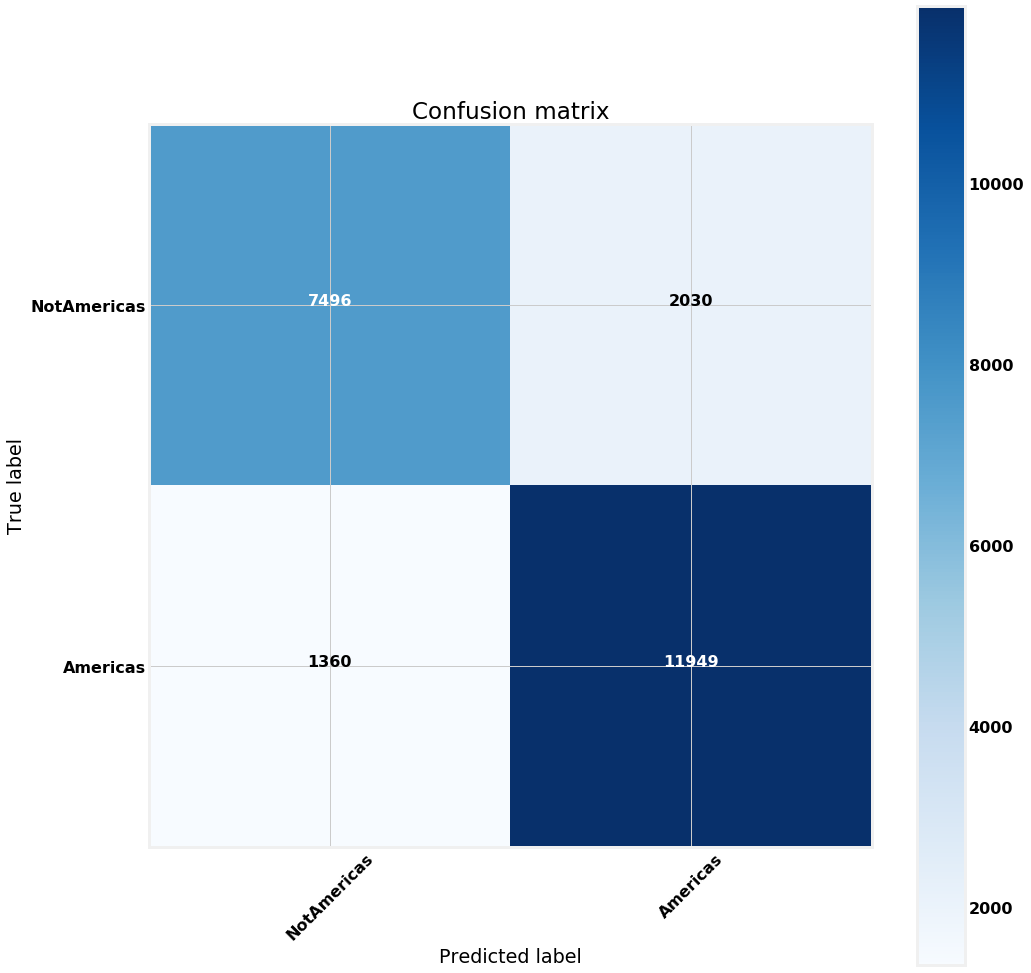

In [41]:
from sklearn.metrics import confusion_matrix
import itertools
cnf_matrix = confusion_matrix(true_values, predictions)
np.set_printoptions(precision=2)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['NotAmericas', 'Americas']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

The model was able to correctly identify non-NA users on the validation set 7496/(7496+2030) = 79% of the time and correctly identify NA users 11949/(11949+1360) = 90% of the time.

Overall, 85% accuracy on the validation set. 